In [37]:
import os

In [38]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'

In [39]:
os.chdir("../")

In [40]:
%pwd

'c:\\Users\\RICH-FILES\\Desktop\\ml'

In [41]:
proj_link = 'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'
os.chdir(proj_link)


In [42]:
# create root entity

from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class ModelTrainerConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_name: str
    preprocessor_name: str
    label_encoder_names: str
    sm_label_encoder: str
    sm_model_name: str
    sm_processor_name: str
    target_column: str
    class_weight: str
    C: float
    random_state: int
    max_iter: int
    penalty: str    
    solver: str
    sm_model_pipeline_name: str

    

In [43]:
proj_link = 'c:\\Users\\RICH-FILES\\Desktop\\ml\\client-subscription-prediction'
os.chdir(proj_link)

In [44]:
#create configuration manager 
#from clientClassifier.constants import *
from clientClassifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH, SCHEMA_FILE_PATH
from clientClassifier.utils.common import read_yaml, create_directories

In [45]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        
        create_directories([self.config.artifacts_root])
        
    def get_model_trainer_config(self) -> ModelTrainerConfig:
        config = self.config.model_trainer     
        params = self.params.Logistic_Regression
        schema = self.schema.TARGET_COLUMN
        
        

        create_directories([config["root_dir"]])

        model_trainer_config = ModelTrainerConfig(
            root_dir=config.root_dir,
            train_data_path=config.train_data_path,
            test_data_path=config.test_data_path,
            model_name=config.model_name,
            preprocessor_name=config.preprocessor_name,
            sm_model_pipeline_name=config.sm_model_pipeline_name,
            label_encoder_names=config.label_encoder_names,
            sm_label_encoder=config.sm_label_encoder,
            sm_model_name=config.sm_model_name,
            sm_processor_name=config.sm_processor_name,
            target_column=schema.name,
            class_weight=params.class_weight,
            max_iter=params.max_iter,
            penalty=params.penalty,
            C=params.C,
            solver=params.solver,
            random_state=params.random_state
        )

        return model_trainer_config


In [46]:
#define model trainer components
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
from clientClassifier import logger
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline   
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier





In [47]:

class ModelTrainer:
    def __init__(self, config: ModelTrainerConfig):
        self.config = config

    def train(self):
        logger.info("Training model")

        # Load train and test data
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)

        # Separate features and target variable
        X_train = train_data.drop(columns=[self.config.target_column], axis=1)
        y_train = train_data[self.config.target_column]

        X_test = test_data.drop(columns=[self.config.target_column], axis=1)
        y_test = test_data[self.config.target_column]

        # Identify numerical and categorical feature columns
        numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Apply Label Encoding to target variable
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)

        # Preprocessing for features
        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

        # Now you can fit a model using preprocessor and encoded targets

        logger.info("Preprocessing and label encoding complete")

        
        # create a pipeline with preprocessing and model
        pipeline = Pipeline([   
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(
                class_weight=self.config.class_weight,
                max_iter=self.config.max_iter,
                penalty=self.config.penalty,
                C=self.config.C,
                solver = self.config.solver,
                random_state=self.config.random_state
            ))
        ])      
        
        # fit the pipeline on the training data
        pipeline.fit(X_train, y_train)      
        
     
        # make predictions on the test data 
        y_pred = pipeline.predict(X_test)      
         
        # evaluate the model
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)   
        accuracy = accuracy_score(y_test, y_pred)   
        
        #create Confusion Matrix Display
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
        disp.plot()
        plt.title("Logistic Regression Matrix without SMOTE")
        
        
        
        
                    

        logger.info(f"Classification Report:\n{report}")
        logger.info(f"Confusion Matrix:\n{cm}") 
        logger.info(f"Accuracy: {accuracy}")   
         
        # save the model    
        
        
        model = pipeline.named_steps['classifier']
        preprocessor = pipeline.named_steps['preprocessor'] 

        model_path = os.path.join(self.config.root_dir, self.config.model_name)                     
        preprocessor_path = os.path.join(self.config.root_dir, self.config.preprocessor_name)
        joblib.dump(preprocessor, preprocessor_path)    
        joblib.dump(model, model_path)
        joblib.dump(label_encoder, os.path.join(self.config.root_dir, self.config.label_encoder_names))
          
        
        logger.info(f"Model saved at: {model_path}")
        logger.info(f"Preprocessor saved at: {preprocessor_path}")      
        
     
        
  
    def train_with_SMOTE(self):
        logger.info("Training model with SMOTE")

        # Load data
        train_data = pd.read_csv(self.config.train_data_path)
        test_data = pd.read_csv(self.config.test_data_path)

        # Separate features and target
        X_train = train_data.drop(columns=[self.config.target_column])
        y_train = train_data[self.config.target_column]

        X_test = test_data.drop(columns=[self.config.target_column])
        y_test = test_data[self.config.target_column]
        
        # Apply Label Encoding to target variable
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(y_train)
        y_test = label_encoder.transform(y_test)

        # Define numerical and categorical features
        numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
        
   
        # Transformers
        numerical_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        sm_preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )

        #  Fitting model on resampled data
        model = LogisticRegression(
            class_weight=self.config.class_weight,
            max_iter=self.config.max_iter,
            penalty=self.config.penalty,
            C=self.config.C,
            solver = self.config.solver,
            random_state=self.config.random_state
        )
        
        # use the sm_pipeline to transform the data
        sm_pipeline = ImbPipeline([
            ('preprocessor', sm_preprocessor),
            ('smote', SMOTE(random_state=self.config.random_state)),
            ('classifier', model)
        ])

        sm_pipeline.fit(X_train, y_train)
            
        # make predictions on the test data 
        y_pred = sm_pipeline.predict(X_test)

        # evaluate the model
        resampled_report = classification_report(y_test, y_pred)
        resampled_cm = confusion_matrix(y_test, y_pred)   
        resampled_accuracy = accuracy_score(y_test, y_pred)
        
        #create Confusion Matrix Display
        cm_display = ConfusionMatrixDisplay(confusion_matrix=resampled_cm, display_labels=label_encoder.classes_)
        cm_display.plot()
        plt.title("Logistic Regression with Matrix SMOTE")
                                            

        logger.info(f"Classification Report:\n{resampled_report}")
        logger.info(f"Confusion Matrix:\n{resampled_cm}") 
        logger.info(f"Accuracy: {resampled_accuracy}")   
            
    
        # Save the model and preprocessor
        joblib.dump(sm_pipeline,
                    os.path.join(self.config.root_dir, 
                    self.config.sm_model_pipeline_name))

        
        
        
   # def train_RandomForest(self):
        #logger.info("Training Random Forest model")

        # Load data
        #train_data = pd.read_csv(self.config.train_data_path)
        #test_data = pd.read_csv(self.config.test_data_path)

        # Separate features and target
        #X_train = train_data.drop(columns=[self.config.target_column])
        #y_train = train_data[self.config.target_column]

        #X_test = test_data.drop(columns=[self.config.target_column])
        #y_test = test_data[self.config.target_column]

        # Define numerical and categorical features
        #numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        #categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Transformers
        #numerical_transformer = StandardScaler()
        #categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        #rf_preprocessor = ColumnTransformer(
            #transformers=[
                #('num', numerical_transformer, numerical_features),
                #('cat', categorical_transformer, categorical_features)
            #]
        #)

        # Preprocess X_train using fit_transform (fit only on training data)
        #X_train_processed = rf_preprocessor.fit_transform(X_train)

        # Fitting Random Forest model on the processed data
        #rf_model = RandomForestClassifier(**self.params.random_forest)
  
        #rf_model.fit(X_train_processed, y_train)

        # make predictions on the test data 
        #X_test_processed = rf_preprocessor.transform(X_test)
        #y_pred_rf = rf_model.predict(X_test_processed)

        # evaluate the model
        #rf_report = classification_report(y_test, y_pred_rf)
        #rf_cm = confusion_matrix(y_test, y_pred_rf)   
        #rf_accuracy = accuracy_score(y_test, y_pred_rf)   

        #logger.info(f"Random Forest Classification Report:\n{rf_report}")
        #logger.info(f"Random Forest Confusion Matrix:\n{rf_cm}") 
        #logger.info(f"Random Forest Accuracy: {rf_accuracy}")
        
        # save the model
        #rf_model_path = os.path.join(self.config.root_dir, self.config.rf_model_name_model_name)   
        #rf_preprocessor_path = os.path.join(self.config.root_dir, self.config.rf_preprocessor_name)
        #joblib.dump(rf_model, rf_model_path)
        #joblib.dump(rf_preprocessor, rf_preprocessor_path)
        #return rf_report, rf_cm, rf_accuracy    
        
    #def train_RandomForest_with_SMOTE(self):
        #logger.info("Training Random Forest model with SMOTE")

        # Load data
        #train_data = pd.read_csv(self.config.train_data_path)
        #test_data = pd.read_csv(self.config.test_data_path)

        # Separate features and target
        #X_train = train_data.drop(columns=[self.config.target_column])
        #y_train = train_data[self.config.target_column]

        #X_test = test_data.drop(columns=[self.config.target_column])
        #y_test = test_data[self.config.target_column]

        # Define numerical and categorical features
        #numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        #categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Transformers
        #numerical_transformer = StandardScaler()
        #categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        #rf_smote_preprocessor = ColumnTransformer(
            #transformers=[
                #('num', numerical_transformer, numerical_features),
                #('cat', categorical_transformer, categorical_features)
            #]
        #)

        # Preprocess X_train using fit_transform (fit only on training data)
        #X_train_processed = rf_smote_preprocessor.fit_transform(X_train)

        # Applying SMOTE to resample training data
        #smote = SMOTE(random_state=self.config.random_state)
        #X_resampled, y_resampled = smote.fit_resample(X_train_processed, y_train)

        #logger.info(f"After SMOTE: {X_resampled.shape}, Target distribution: {dict(pd.Series(y_resampled).value_counts())}")

        # Fitting Random Forest model on the processed data
        #rf_model = RandomForestClassifier(**self.params.random_forest)

        #rf_model.fit(X_resampled, y_resampled)

        # make predictions on the test data 
        #X_test_processed = rf_smote_preprocessor.transform(X_test)
        #y_pred_rf_smote = rf_model.predict(X_test_processed)

        # evaluate the model
        #rf_smote_report = classification_report(y_test, y_pred_rf_smote)
        #rf_smote_cm = confusion_matrix(y_test, y_pred_rf_smote)   
        #rf_smote_accuracy = accuracy_score(y_test, y_pred_rf_smote)   

        #logger.info(f"Random Forest with SMOTE Classification Report:\n{rf_smote_report}") 
        #logger.info(f"Random Forest with SMOTE Confusion Matrix:\n{rf_smote_cm}")
        #logger.info(f"Random Forest with SMOTE Accuracy: {rf_smote_accuracy}")
        
        # save the model
        #rf_smote_model_path = os.path.join(self.config.root_dir, self.config.rf_smote_model_name)
        #rf_smote_preprocessor_path = os.path.join(self.config.root_dir, self.config.rf_smote_preprocessor_name)
        #joblib.dump(rf_model, rf_smote_model_path)
        #joblib.dump(rf_smote_preprocessor, rf_smote_preprocessor_path)  
        #return rf_smote_report, rf_smote_cm, rf_smote_accuracy  
    
    
    #def train_XGBClassifier(self):
        #logger.info("Training XGBoost model")

        # Load data
        #train_data = pd.read_csv(self.config.train_data_path)
        #test_data = pd.read_csv(self.config.test_data_path)

        # Separate features and target
        #X_train = train_data.drop(columns=[self.config.target_column])
        #y_train = train_data[self.config.target_column]

        #X_test = test_data.drop(columns=[self.config.target_column])
        #y_test = test_data[self.config.target_column]

        # Define numerical and categorical features
        #numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        #categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Transformers
        #numerical_transformer = StandardScaler()
        #categorical_transformer = OneHotEncoder(handle_unknown='ignore')

        #xgb_preprocessor = ColumnTransformer(
            #transformers=[
                #('num', numerical_transformer, numerical_features),
                #('cat', categorical_transformer, categorical_features)
            #]
        #)

        # Preprocess X_train using fit_transform (fit only on training data)
        #X_train_processed = xgb_preprocessor.fit_transform(X_train)

        # Fitting XGBoost model on the processed data
        #xgb_model = XGBClassifier(random_state=self.config.random_state,
                                   #n_estimators=self.config.n_estimators,
                                   #max_depth=self.config.max_depth,
                                   #class_weight= self.config.class_weight)
        
          
        #xgb_model.fit(X_train_processed, y_train)

        # make predictions on the test data 
        #X_test_processed = xgb_preprocessor.transform(X_test)
        #y_pred_xgb = xgb_model.predict(X_test_processed)

        # evaluate the model
        #xgb_report = classification_report(y_test, y_pred_xgb)
        #xgb_cm = confusion_matrix(y_test, y_pred_xgb)   
        #xgb_accuracy = accuracy_score(y_test, y_pred_xgb)   

        #logger.info(f"XGBoost Classification Report:\n{xgb_report}")
        #logger.info(f"XGBoost Confusion Matrix:\n{xgb_cm}") 
        #logger.info(f"XGBoost Accuracy: {xgb_accuracy}")
        
        # save the model
        #xgb_model_path = os.path.join(self.config.root_dir, self.config.xgb_model_name)   
        #xgb_preprocessor_path = os.path.join(self.config.root_dir, self.config.xgb_preprocessor_name)
        #joblib.dump(xgb_model, xgb_model_path)
        #joblib.dump(xgb_preprocessor, xgb_preprocessor_path)
        #return xgb_report, xgb_cm, xgb_accuracy
    
        
            
        
        
        
            

[2025-04-20 18:34:42,493: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-20 18:34:42,502: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-20 18:34:42,523: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-20 18:34:42,529: INFO: common: created directory at: artifacts]
[2025-04-20 18:34:42,532: INFO: common: created directory at: artifacts/model_trainer]
[2025-04-20 18:34:42,535: INFO: 3220922547: Training model]
[2025-04-20 18:34:42,614: INFO: 3220922547: Preprocessing and label encoding complete]
[2025-04-20 18:34:43,001: INFO: 3220922547: Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.70      0.79       807
           1       0.17      0.51      0.25        98

    accuracy                           0.68       905
   macro avg       0.55      0.60      0.52       905
weighted avg       0.84      0.68      0.73       905
]
[2025-04-20 18:34:43,003: INFO: 3220922

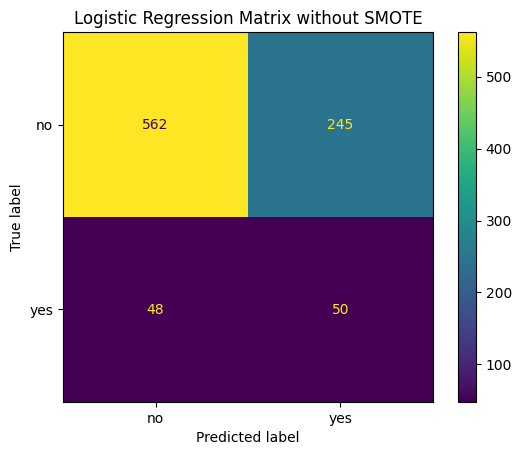

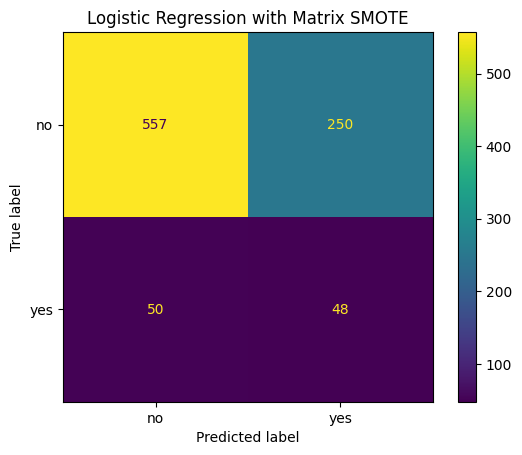

In [48]:


try:
    config = ConfigurationManager()
    model_trainer_config = config.get_model_trainer_config()
    model_trainer = ModelTrainer(model_trainer_config)
    model_trainer.train()
    model_trainer.train_with_SMOTE()     
except Exception as e:
    logger.exception(e)
    raise e 

